<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Differences-between-atari-and-animalai-environment" data-toc-modified-id="Differences-between-atari-and-animalai-environment-1">Differences between atari and animalai environment</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Environment-creation" data-toc-modified-id="Environment-creation-1.2">Environment creation</a></span></li><li><span><a href="#Checking-atari-output" data-toc-modified-id="Checking-atari-output-1.3">Checking atari output</a></span><ul class="toc-item"><li><span><a href="#Reset" data-toc-modified-id="Reset-1.3.1">Reset</a></span></li><li><span><a href="#Step" data-toc-modified-id="Step-1.3.2">Step</a></span></li></ul></li><li><span><a href="#Verifying-the-same-on-AnimalAI" data-toc-modified-id="Verifying-the-same-on-AnimalAI-1.4">Verifying the same on AnimalAI</a></span><ul class="toc-item"><li><span><a href="#Reset" data-toc-modified-id="Reset-1.4.1">Reset</a></span></li><li><span><a href="#Step" data-toc-modified-id="Step-1.4.2">Step</a></span></li></ul></li><li><span><a href="#Wrapper" data-toc-modified-id="Wrapper-1.5">Wrapper</a></span></li><li><span><a href="#Old" data-toc-modified-id="Old-1.6">Old</a></span></li></ul></li></ul></div>

# Differences between atari and animalai environment

On this notebook I want to try to fix the differences between atari and animalai environment.

## Imports

In [15]:
import time
import gym
import os
import sys
import matplotlib.pyplot as plt

from animalai.envs import UnityEnvironment
from animalai.envs.arena_config import ArenaConfig
from animalai.envs.exception import UnityWorkerInUseException

from animalai.envs.gym.environment import AnimalAIEnv

%matplotlib inline

In [6]:
sys.path.append('/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/piojanu_planet')
import planet
from planet import control


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Environment creation

In [23]:
def animalai_environment(config_filepath='/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/orangutan/data/env_configs/4multi.yaml'):
    ENVIRONMENT_FILEPATH = '/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/env/AnimalAI.x86_64'
    worker_id = 0
    arena_config = ArenaConfig(config_filepath)
    while worker_id < 10:
        try:
            env = AnimalAIEnv(
                environment_filename=ENVIRONMENT_FILEPATH,   # Path to the environment
                worker_id=worker_id,                # Unique ID for running the environment (used for connection)
                seed=int(os.getenv('ENV_SEED', 0)),                     # The random seed
                docker_training=False,      # Whether or not you are training inside a docker
                n_arenas=1,                 # Number of arenas in your environment
                inference=False,            # Set to true to watch your agent in action
                resolution=None,             # Int: resolution of the agent's square camera (in [4,512], default 84),
                arenas_configurations=arena_config,
            )
            break
        except UnityWorkerInUseException:
            worker_id += 1
            print('Increasing worker_id: %i' % worker_id)
    env.reset()
    return env

In [7]:
def _gym_env(action_repeat, min_length, max_length, name,
             act_is_discrete=False, obs_is_image=False):
  if "Sokoban" in name:
    import gym_sokoban
  import gym
  env = gym.make(name)
  env = env.env  # Remove the TimeLimit wrapper
  env.frameskip = 1  # Disable Gym frame skipping
  env = control.wrappers.ActionRepeat(env, action_repeat)
  if act_is_discrete:
    env = control.wrappers.DiscreteWrapper(env)
  else:
    env = control.wrappers.NormalizeActions(env)
  env = control.wrappers.MinimumDuration(env, min_length)
  env = control.wrappers.MaximumDuration(env, max_length)
  if obs_is_image:
    env = control.wrappers.ObservationDict(env, 'image')
    env = control.wrappers.ObservationToRender(env)
  else:
    env = control.wrappers.ObservationDict(env, 'state')
  env = control.wrappers.PixelObservations(env, (64, 64), np.uint8, 'image')
  env = control.wrappers.ConvertTo32Bit(env)
  return env

In [3]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
    time.sleep(0.01)
env.close()

/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/gym/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Checking atari output

In [ ]:
atari_env = _gym_env(action_repeat=1, act_is_discrete=True, obs_is_image=True, name='Boxing-v0', min_length=50, max_length=2000)

### Reset

In [10]:
ret = atari_env.reset()

In [12]:
print(len(ret))
print(ret.keys())
print(ret['image'].shape)

1
dict_keys(['image'])
(64, 64, 3)


The reset method returns a dictionary with just an image. 

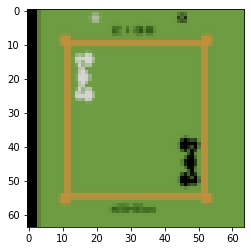

In [16]:
plt.imshow(ret['image'])

### Step

In [17]:
ret = atari_env.step(0) 

In [20]:
print(len(ret))
print(ret[1:])
print(ret[0].keys())
print(ret[0]['image'].shape)

4
(array(0., dtype=float32), False, {'ale.lives': 0})
dict_keys(['image'])
(64, 64, 3)


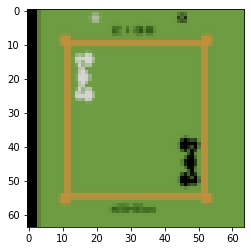

In [21]:
plt.imshow(ret[0]['image'])

The step method returns four elements:
* The dictionary with the image same as reset method
* reward
* is_done
* dictionary with other information

## Verifying the same on AnimalAI

In [24]:
animal_env = animalai_environment()

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
INFO:gym_unity:1 agents within environment.


### Reset

In [25]:
ret = animal_env.reset()

In [28]:
ret.shape

(84, 84, 3)

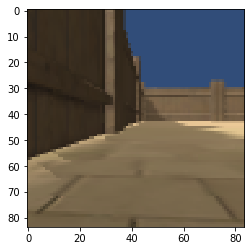

In [30]:
plt.imshow(ret)

AnimalAI reset returns the image but not in a dictionary.

### Step

In [31]:
ret = animal_env.step(0) 

In [33]:
print(len(ret))
print(ret[1:])
print(ret[0].shape)

4
(-0.001999999862164259, False, {'text_observation': '', 'brain_info': <animalai.envs.brain.BrainInfo object at 0x7f3a285cd4e0>})
(84, 84, 3)


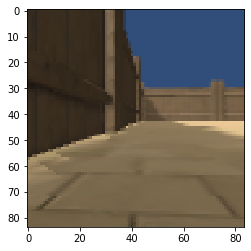

In [34]:
plt.imshow(ret[0])

Again we saw that the output is the same except that the image is not inside a dictionary.

## Wrapper

Let's try to solve that using wrappers.

In [35]:
def wrap_animal(env):
    env = control.wrappers.ObservationDict(env, 'image')
    return env

In [36]:
env = wrap_animal(animal_env)

In [37]:
ret = env.reset()

In [38]:
print(len(ret))
print(ret.keys())
print(ret['image'].shape)

1
dict_keys(['image'])
(84, 84, 3)


In [39]:
ret = env.step(0)

In [40]:
print(len(ret))
print(ret[1:])
print(ret[0].keys())
print(ret[0]['image'].shape)

4
(-0.001999999862164259, False, {'text_observation': '', 'brain_info': <animalai.envs.brain.BrainInfo object at 0x7f3a24180320>})
dict_keys(['image'])
(84, 84, 3)


With this wrapper it seems that the environments are equal.
I have added another wrapper to remove brain_info and it is advancing in the training

In [41]:
vars(env)

{'_env': <animalai.envs.gym.environment.AnimalAIEnv at 0x7f3a285bd6d8>,
 '_key': 'image'}

## Old

In [6]:
vars(atari_env)

{'env': <gym.envs.atari.atari_env.AtariEnv at 0x7f59ea1a8f28>,
 'action_space': Discrete(18),
 'observation_space': Box(210, 160, 3),
 'reward_range': (-inf, inf),
 'metadata': {'render.modes': ['human', 'rgb_array']},
 '_max_episode_steps': 10000,
 '_elapsed_steps': 0}

In [13]:
vars(animal_env)

{'_env': <animalai.envs.environment.UnityEnvironment at 0x7f59ea22ec88>,
 'vector_obs': array([ 0.        , -0.00283241,  0.        ]),
 'inference': False,
 'resolution': None,
 '_current_state': <animalai.envs.brain.BrainInfo at 0x7f59ea383160>,
 '_n_agents': 1,
 '_flattener': <animalai.envs.gym.environment.ActionFlattener at 0x7f59ea36def0>,
 '_greyscale': False,
 'retro': False,
 'game_over': False,
 'arenas_configurations': <animalai.envs.arena_config.ArenaConfig at 0x7f59ea22ebe0>,
 'flatten_branched': True,
 'uint8_visual': False,
 'brain_name': 'Learner',
 '_action_space': Discrete(9),
 'action_meanings': ['', ''],
 '_observation_space': Tuple(Box(1, 84, 84, 3), Box(1, 3)),
 'visual_obs': array([[[0.19215686, 0.30196078, 0.4745098 ],
         [0.19215686, 0.30196078, 0.4745098 ],
         [0.19215686, 0.30196078, 0.4745098 ],
         ...,
         [0.19215686, 0.30196078, 0.4745098 ],
         [0.19215686, 0.30196078, 0.4745098 ],
         [0.19215686, 0.30196078, 0.4745098 ]]

In [4]:
animal_env = animalai_environment()

Increasing worker_id: 1


INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
INFO:gym_unity:1 agents within environment.


In [14]:
animal_env.step(0)[0].shape

(84, 84, 3)

In [15]:
atari_env.step([0])[0].shape

(210, 160, 3)